# P3 submission: Loading and Preprocessing part

In [2]:
# import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import os
import warnings
import spacy

from textblob import TextBlob
from IPython.display import display, HTML, Markdown

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import string
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud
from collections import Counter

# statistics
from scipy.stats import ttest_rel, ttest_ind
import statsmodels.formula.api as smf

warnings.filterwarnings('ignore') # remove the warnings

# Load ratings.txt

We are processing data extracted from two similar beer rating websites: BeerAdvocate and RateBeer. The primary data structure is outlined in "ratings.txt," which includes user reviews providing information on beer (names, IDs, style, alcohol by volume), breweries, and users (date of review, user details, ratings, and comments on various aspects). Other supporting files include "beers.csv" (aggregated ratings for each beer), "Breweries" (information on breweries and their locations), and "Users" (user details on the number of ratings, reviews, and country of origin).

The most crucial file is "ratings.txt," as others are derived from its content. Due to its significant size (4.3 GB for BeerAdvocate and 3.95 GB for RateBeer), loading directly with a standard pipeline is impractical due to laptop memory limitations. To address this, we split the .txt files into N subfiles and load the data iteratively using a function.

The function allows control over the fraction of initial data loaded via the parameter **Nb_files**, which determines the number of subfiles to load. It also accommodates inherent differences between the two websites, such as additional review columns for BeerAdvocate.

Once loaded into DataFrames, we utilize the sample_data function to randomly sample a fraction of the data, enabling efficient handling of the substantial dataset.

In [3]:
def load_txt_file(website, Nb_files):
    if website == 'BeerAdvocate':
        # Specify the directory containing the text files 
        # Need to be outside of the repo folder and might need to change the path according to one's unique folders configuration
        directory = './../../dataset_BeerReviews/BeerAdvocate/ratings_split_BA/'
    else:
        directory = './../../dataset_BeerReviews/RateBeer/ratings_split_RB/'

    # Initialize an empty list to store DataFrames
    dfs = []

    # Loop through the files in reverse order (ratings-5.txt to ratings-1.txt)
    for i in range(Nb_files, 0, -1):
        file_name = f'ratings-{i}.txt'
        file_path = os.path.join(directory, file_name)

        with open(file_path, 'r') as f:
            text = f.read()

        # Remove double quotes at the beginning of each line
        data = re.sub('"', '', text)
        data = re.sub(r'^"', '', data, flags=re.MULTILINE)

        # Split the text into individual beer reviews
        beer_reviews = data.split('beer_name')

        # Extract the beer information from each review
        beer_data = []
        for review in beer_reviews:
            beer_info = {}
            for line in [entry.split(':', 1) for entry in review.split('\n') if ':' in entry]:# and 'text' not in entry]:
                if line:  # Check if the list is not empty
                    key, value = line[0].strip(), line[1].strip()
                    beer_info[key] = value
            beer_data.append(beer_info)

        # Convert the beer data into a DataFrame
        df = pd.DataFrame(beer_data)

        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(dfs, ignore_index=True)

    # Rename the columns depending on the website
    if website == 'BeerAdvocate':
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text',
            'review'] # additional column compared to RB
    else:
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text']
    return final_df

def sample_data(df, ratio):
    # sample the data to make it even smaller
    return df.sample(frac = ratio, random_state=42)

In [5]:
# Load data : for faster processing, we will only load 1 file out of the whole dataset
ratings_BA = load_txt_file('BeerAdvocate', 3)
ratings_RB = load_txt_file('RateBeer', 3)

In [6]:
# Sample data to make it even smaller AND RANDOMIZED (not randomized in the initial txt splitting process)
ratings_BA = sample_data(df = ratings_BA, ratio = 0.25)
ratings_RB = sample_data(df = ratings_RB, ratio = 0.25)

In [7]:
print(f"Length of ratings_BA (BeerAdvocate) dataframe : {len(ratings_BA)}")
print(f"Length of ratings_RB (RateBeer) dataframe : {len(ratings_RB)}")
display(ratings_BA.head(2),ratings_RB.head(2))

Length of ratings_BA (BeerAdvocate) dataframe : 333254
Length of ratings_RB (RateBeer) dataframe : 314997


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
330825,The Devil Made Me Do It! Coffee Imperial Oatme...,35201,Tyranena Brewing Company,784,American Porter,7.5,1208944800,francisweizen,francisweizen.964,4.0,4.0,4.0,4.0,4.0,4.00,Black with a small tan head of foam that quick...,True
550376,Hop Burn High,76730,Mikkeller ApS,13307,American Double / Imperial IPA,10.0,1357729200,stlunatic15,stlunatic15.657107,nan,nan,nan,nan,nan,3.75,nan,False


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
852356,Dia De Los Muertos Immortal Beloved Hefeweizen,218797,Cervecería Mexicana (Grupo Modelo),5973,German Hefeweizen,5.5,1454410800,msbernac,276579,3,6,3,5,11,2.80,"BottleAroma-banana, cloveAppearance-amber, clo..."
658121,Gundestrup Ale,86884,Gundestrup Mejeri og Bryghus,9485,American Pale Ale,6.0,1209463200,Christian,7513,3,7,3,6,13,3.20,Thank you JensenTaster for letting us have the...


### Load the other data

In [8]:
# BeerAdvocate
beers_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/beers.csv")
breweries_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/breweries.csv")
users_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/users.csv")

# RateBeer
beers_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/beers.csv")
breweries_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/breweries.csv")
users_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/users.csv")

# matched_beer_data
beers_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/beers.csv", header=1)
breweries_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/breweries.csv", header = 1)
ratings_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/ratings.csv", header=1)
users_approx = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users_approx.csv", header=1)
users_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users.csv", header=1)

**Check the type**

In [9]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,object,object
brewery_name,object,object
brewery_id,object,object
style,object,object
abv,object,object
date,object,object
user_name,object,object
user_id,object,object
appearance,object,object


**Change the type**

One can see that all the features of **ratings_BA** and **ratings_RB** have a `object` type, which is not very convenient if we want to automate the visualization process, for example plotting the distribution of the numerical features in histograms. As a first preprocessing step, we will thus convert the type of the numerical variables to `float64` with the function **convert_type** below.

In [10]:
def convert_type(df, col):
    df[col] = df[col].astype('float64')
    return df

# columns including the numerical features for both websites
# user_id is numerical in RB but categorical in BA so we don't include it
numerical_cols = ['beer_id', 'brewery_id', 'abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

for col in numerical_cols : 
    ratings_BA = convert_type(ratings_BA, col)
    ratings_RB = convert_type(ratings_RB, col)

In [11]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,float64,float64
brewery_name,object,object
brewery_id,float64,float64
style,object,object
abv,float64,float64
date,object,object
user_name,object,object
user_id,object,object
appearance,float64,float64


## Combine all the dataframes

- matched (already standardized, need to check scales though of numerical features)
- BA (not standardized yet)
- RB (not standardized yet)

First we need to standardize the data from ratings_BA and ratings_RB before combining them with matched (which has already been standardized per year and per website, see paper)

Explain that we duplicate the matched samples (1 from BA and 1 from RB), so that we keep all the reviews, independently of the website.

### Preprocessing : standardize ratings_BA and ratings_RB annually

- Need to add time dimension first: month and year

In [12]:
def add_time_features(df):
    """
    Adds a 'month' and a 'year' features to the DataFrame based on the 'date' column.
    
    Parameters
    ----------
    df : DataFrame
        Contains data including a 'date' column.

    Returns
    -------
    df_m : DataFrame
        Contains the original data with an additional 'month' and 'year' features.
    """
    # Create a copy of the DataFrame
    df_time = df.copy()
    # Conversion of date feature from timestamp to text date
    pd.to_numeric(df_time['date'], errors='coerce', downcast='integer')
    # Convert 'date' to datetime and extract the date
    df_time.date = df.date.apply(lambda d: pd.to_datetime(d, unit='s'))
    df_time['date'] = df_time['date'].dt.date

    # Extract the month from the 'date' column and add it as a new feature 'month'
    df_time['month'] = pd.to_datetime(df_time['date']).dt.month
    # Extract the year from the 'date' column and add it as a new feature 'year'
    df_time['year'] = pd.to_datetime(df_time['date']).dt.year

    return df_time

def standardize_annually_ratings(df):
    """
    Standardizes the ratings annually and per website.
    
    Parameters
    ----------
    df : DataFrame
        Containing all data

    Returns
    -------
    df : DataFrame
        Containing all data with standardized ratings with additional column 'standardized_rating'.
                
    """
    df_copy = df.copy()
    grouped = df_copy.groupby('year')['rating'].agg(['mean', 'std'])
    df_copy = pd.merge(df_copy, grouped, left_on='year', right_index=True)
    df_copy['std_rating'] = (df_copy['rating'] - df_copy['mean']) / df_copy['std']
    
    return df_copy, grouped

In [13]:
# add time feature to standardize ratings by year and by website
ratings_BA_with_time = add_time_features(ratings_BA)
ratings_RB_with_time = add_time_features(ratings_RB)

# apply standardization
ratings_BA_standardized, mean_std_BA = standardize_annually_ratings(ratings_BA_with_time)
ratings_RB_standardized, mean_std_RB = standardize_annually_ratings(ratings_RB_with_time)

In [14]:
def plot_mean_std_errorbar(grouped_BA, grouped_RB):
    plt.figure(figsize=(7, 7))
    plt.subplot(2, 1, 1)
    plt.errorbar(grouped_BA.index, grouped_BA['mean'], yerr=1.96 * grouped_BA['std'] / np.sqrt(grouped_BA['std'].count()), fmt='o', capsize=5, linestyle='-', label = 'BeerAdvocate')
    plt.errorbar(grouped_RB.index, grouped_RB['mean'], yerr=1.96 * grouped_RB['std'] / np.sqrt(grouped_RB['std'].count()), fmt='o', capsize=5, linestyle='-', label = 'RateBeer')
    plt.title('Mean Ratings across Years')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.errorbar(grouped_BA.index, grouped_BA['std'], yerr=1.96 * grouped_BA['std'] / np.sqrt(grouped_BA['std'].count()), fmt='o', capsize=5, linestyle='-', label = 'BeerAdvocate')
    plt.errorbar(grouped_RB.index, grouped_RB['std'], yerr=1.96 * grouped_RB['std'] / np.sqrt(grouped_RB['std'].count()), fmt='o', capsize=5, linestyle='-', label = 'RateBeer')
    plt.title('Standard Deviation of Ratings across Years')
    plt.tight_layout()
    plt.legend()
    plt.show()

### Some plots

Before standardization


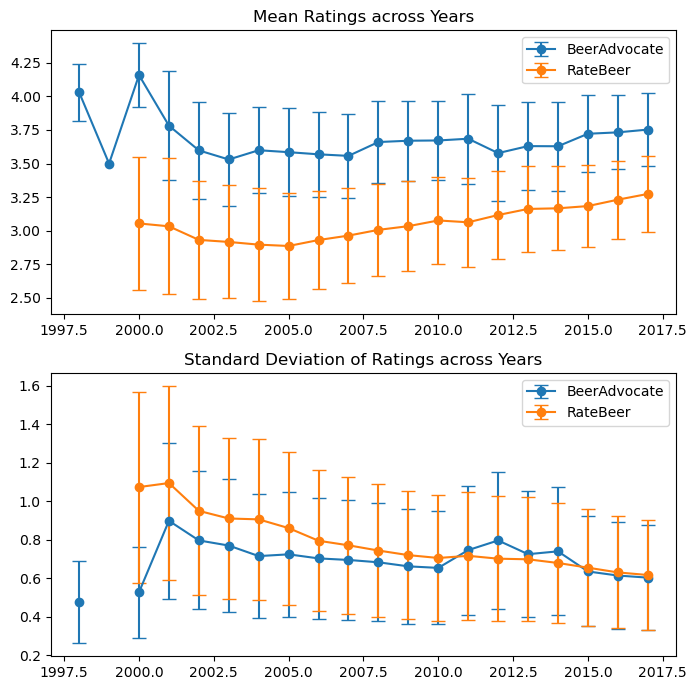

In [15]:
print("Before standardization")
plot_mean_std_errorbar(mean_std_BA, mean_std_RB)

After standardization


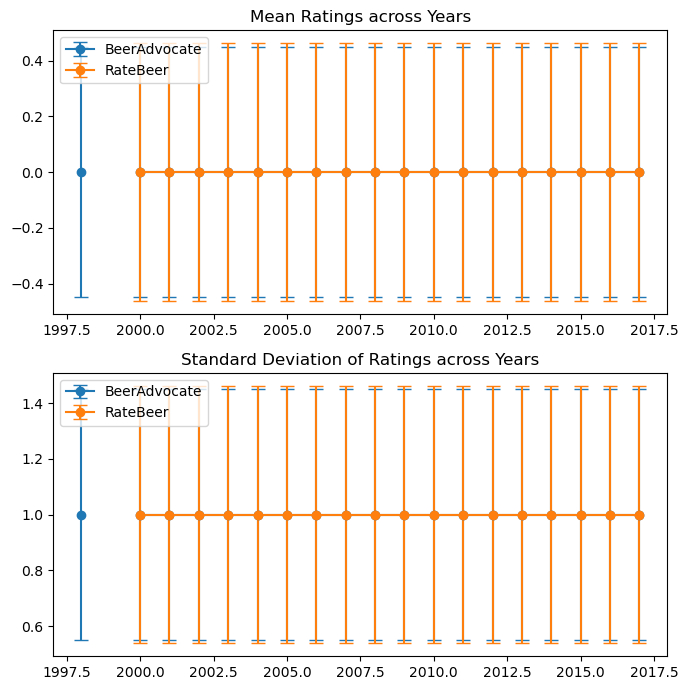

In [16]:
mean_std_BA_standardized = ratings_BA_standardized.groupby('year')['std_rating'].agg(['mean', 'std'])
mean_std_RB_standardized = ratings_RB_standardized.groupby('year')['std_rating'].agg(['mean', 'std'])
print("After standardization")
plot_mean_std_errorbar(mean_std_BA_standardized, mean_std_RB_standardized)

We still need to standardize the ratings from matched

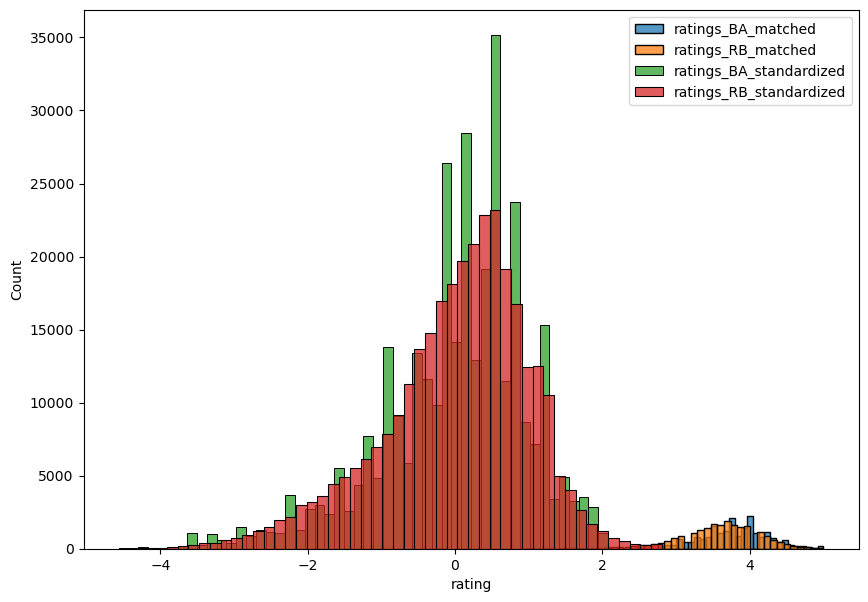

In [17]:
plt.figure(figsize=(10, 7))
sns.histplot(data=ratings_matched['rating'], bins=50, label = 'ratings_BA_matched')
sns.histplot(data=ratings_matched['rating.1'], bins=50, label = 'ratings_RB_matched')
sns.histplot(data=ratings_BA_standardized['std_rating'], bins=50, label = 'ratings_BA_standardized')
sns.histplot(data=ratings_RB_standardized['std_rating'], bins=50, label = 'ratings_RB_standardized')
plt.legend()
plt.show()

Standardize ratings from the matched

In [19]:
ratings_matched_copy = ratings_matched.copy(deep=True)
ratings_matched_copy['beer_id.1'] = ratings_matched_copy['beer_id']
ratings_matched_copy['brewery_id.1'] = ratings_matched_copy['brewery_id']
ratings_matched_copy['beer_name.1'] = ratings_matched_copy['beer_name']
ratings_matched_copy['brewery_name.1'] = ratings_matched_copy['brewery_name']

# Retrieve the columns of interest for BeerAdvocate
ratings_matched_BA = ratings_matched_copy.iloc[:, :17]
ratings_matched_BA = ratings_matched_BA.drop(['review'], axis=1) # drop the column that is not common to both websites

# Retrieve the columns of interest for RateBeer
ratings_matched_RB = ratings_matched_copy.iloc[:, 17:]
ratings_matched_RB['overall.1'] = ratings_matched_RB['overall.1']*5/20
ratings_matched_RB['aroma.1'] = ratings_matched_RB['aroma.1']*5/10
ratings_matched_RB['taste.1'] = ratings_matched_RB['taste.1']*5/10
ratings_matched_RB.columns = ratings_matched_BA.columns

# add time features to standardize by year
ratings_matched_BA_with_time = add_time_features(ratings_matched_BA)
ratings_matched_RB_with_time = add_time_features(ratings_matched_RB)

# standardize ratings of matched data to have mean 0 and std 1
ratings_matched_BA_standardized, mean_std_BA_matched = standardize_annually_ratings(ratings_matched_BA_with_time) # adds column 'std_rating'
ratings_matched_RB_standardized, mean_std_RB_matched = standardize_annually_ratings(ratings_matched_RB_with_time) # adds column 'std_rating'

### Check

- all dataframes have an additional column 'std_rating' with the standardized rating.

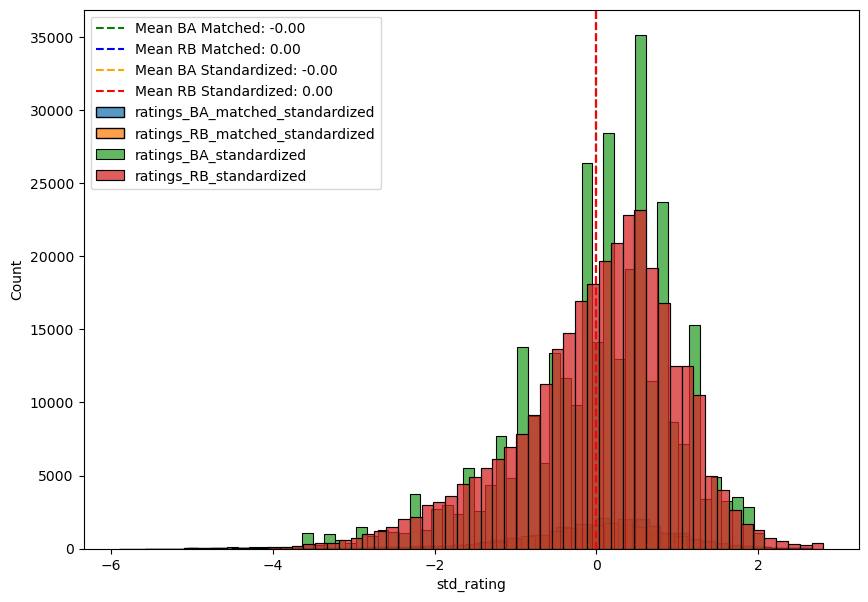

In [20]:
# Compute mean values for each distribution
mean_rating_BA_matched = ratings_matched_BA_standardized['std_rating'].mean()
mean_rating_RB_matched = ratings_matched_RB_standardized['std_rating'].mean()
mean_rating_BA_standardized = ratings_BA_standardized['std_rating'].mean()
mean_rating_RB_standardized = ratings_RB_standardized['std_rating'].mean()


plt.figure(figsize=(10, 7))
sns.histplot(data=ratings_matched_BA_standardized['std_rating'], bins=50, label = 'ratings_BA_matched_standardized')
sns.histplot(data=ratings_matched_RB_standardized['std_rating'], bins=50, label = 'ratings_RB_matched_standardized')
sns.histplot(data=ratings_BA_standardized['std_rating'], bins=50, label = 'ratings_BA_standardized')
sns.histplot(data=ratings_RB_standardized['std_rating'], bins=50, label = 'ratings_RB_standardized')

# Plot vertical lines for mean values
plt.axvline(x=mean_rating_BA_matched, color='green', linestyle='--', label=f'Mean BA Matched: {mean_rating_BA_matched:.2f}')
plt.axvline(x=mean_rating_RB_matched, color='blue', linestyle='--', label=f'Mean RB Matched: {mean_rating_RB_matched:.2f}')
plt.axvline(x=mean_rating_BA_standardized, color='orange', linestyle='--', label=f'Mean BA Standardized: {mean_rating_BA_standardized:.2f}')
plt.axvline(x=mean_rating_RB_standardized, color='red', linestyle='--', label=f'Mean RB Standardized: {mean_rating_RB_standardized:.2f}')

plt.legend()
plt.show()

### Concatenate everything

Length of ratings matched: 21964
Length of ratings BA: 333254
Length of ratings RB: 314997
Length of combined dataset: 692177


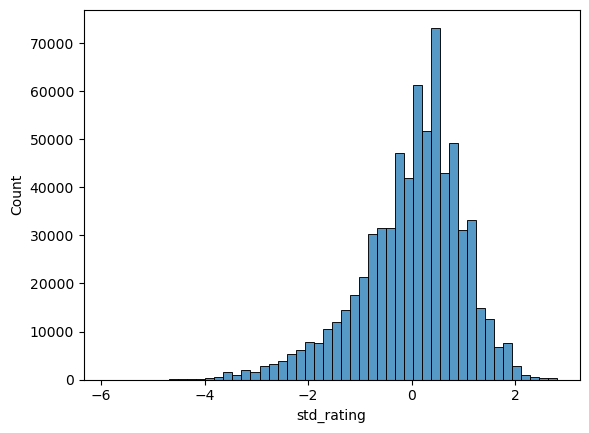

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,taste,overall,rating,text,review,month,year,mean,std,std_rating
330825,The Devil Made Me Do It! Coffee Imperial Oatme...,35201.0,Tyranena Brewing Company,784.0,American Porter,7.50,2008-04-23,francisweizen,francisweizen.964,4.0,...,4.0,4.0,4.00,Black with a small tan head of foam that quick...,True,4.0,2008.0,3.660248,0.682959,0.497471
182582,Miller Lite,332.0,Miller Brewing Co.,105.0,Light Lager,4.17,2008-10-27,jwweaver77,jwweaver77.260040,3.0,...,1.5,1.5,1.64,"appearance: yellow, pale gold colorsmell: some...",True,10.0,2008.0,3.660248,0.682959,-2.958083


In [24]:
# concatenate matched data from both websites
ratings_matched_BA_RB = pd.concat([ratings_matched_BA_standardized, ratings_matched_RB_standardized], axis=0)
ratings_matched_BA_RB.sort_values(by=['beer_id', 'user_id'], inplace=True)

# concatenate matched data with ratings_BA and ratings_RB
all_data= pd.concat([ratings_BA_standardized, 
                    ratings_RB_standardized,
                    ratings_matched_BA_RB], axis=0)

# test
print(f"Length of ratings matched: {len(ratings_matched)}")
print(f"Length of ratings BA: {len(ratings_BA)}")
print(f"Length of ratings RB: {len(ratings_RB)}")
print(f"Length of combined dataset: {len(all_data)}")

# check
sns.histplot(data=all_data['std_rating'], bins=50)
plt.show()

all_data.head(2)

**Copy paste this code until here to load and combine the dataset correctly**

NB: rating to use: **std_rating**

### **Loading and preprocessing done**

---


In [40]:
dataset_test=all_data[:100000]
dataset_test.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,taste,overall,rating,text,review,month,year,mean,std,std_rating
330825,The Devil Made Me Do It! Coffee Imperial Oatme...,35201.0,Tyranena Brewing Company,784.0,American Porter,7.50,2008-04-23,francisweizen,francisweizen.964,4.0,...,4.0,4.0,4.00,Black with a small tan head of foam that quick...,True,4.0,2008.0,3.660248,0.682959,0.497471
182582,Miller Lite,332.0,Miller Brewing Co.,105.0,Light Lager,4.17,2008-10-27,jwweaver77,jwweaver77.260040,3.0,...,1.5,1.5,1.64,"appearance: yellow, pale gold colorsmell: some...",True,10.0,2008.0,3.660248,0.682959,-2.958083


In [27]:
mean_words= np.mean(dataset_test['text'].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews : {mean_words}")

Average number of words in textual reviews : 219.0937


In [41]:
def get_top_n_i_gram(corpus, i, n=None):
    """
    Extracts the top 'n' n-grams from a corpus.
    
    Parameters
    ----------
    corpus : Series or list
        Contains text data.
    i : int
        Specifies the 'i' in n-grams.
    n : int, optional
        Specifies the number of top n-grams to return. Default is None.

    Returns
    -------
    words_freq : list
        Contains tuples of n-grams and their frequencies.
    """
    # Drop rows with NaN values in the 'text' column
    corpus = corpus[corpus.str.strip().astype(bool)]
    corpus = corpus[corpus != 'nan']
    # Fit CountVectorizer with specified n-gram range
    vec = CountVectorizer(ngram_range=(i,i)).fit(corpus)
    # Transform the corpus into a bag of words
    bag_of_words = vec.transform(corpus)
    # Sum the occurrences of each word across the corpus
    sum_words = bag_of_words.sum(axis=0) 
    # Create a list of tuples containing words and their frequencies
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sort the list by frequency in descending order
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [43]:
# can take 5-7 min to run
N = 20

common_unigrams = get_top_n_i_gram(dataset_test['text'], 1, N)
common_bigrams = get_top_n_i_gram(dataset_test['text'], 2, N)
common_trigrams = get_top_n_i_gram(dataset_test['text'], 3, N)

[('the', 155304),
 ('and', 123636),
 ('of', 99172),
 ('with', 73275),
 ('is', 71305),
 ('it', 58015),
 ('to', 54747),
 ('this', 46763),
 ('in', 41340),
 ('but', 39466),
 ('beer', 36177),
 ('that', 32821),
 ('head', 29387),
 ('very', 27908),
 ('not', 26846),
 ('some', 26645),
 ('on', 25565),
 ('as', 23530),
 ('light', 22755),
 ('for', 22391)]

In [44]:
import pandas as pd
import nltk
nltk.download('words')
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
#import fasttext

nltk.download('stopwords') # Download NLTK stopwords
nltk.download('wordnet')   # Lemmatization
nltk.download('words')
english_words=set(words.words())
# Get the set of English stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [46]:

from translate import Translator


def preprocess_sentences(df):    
    # Remove rows with no sentences (NaN values or empty sentences)
    df = df.dropna(subset=['text'])
    df = df[df['text'].str.strip().astype(bool)]
    df = df[df['text'] != 'nan']
    # Rest of the code remains the same
    def clean_text(sentence):
        translator = str.maketrans('', '', string.punctuation)
        cleaned = sentence.translate(translator).lower()
        return cleaned

    def lemmatize_text(sentence):
        tokens = word_tokenize(sentence)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmatized_tokens)

    def remove_stopwords(sentence):
        tokens = word_tokenize(sentence)
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
        return ' '.join(filtered_tokens)

    def keep_only_english(sentence):
        return " ".join(w for w in nltk.wordpunct_tokenize(sentence) if w.lower() in english_words or not w.isalpha())
    



    df['cleaned_text'] = df['text'].apply(clean_text)
    df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)
    df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)
    df['cleaned_text'] = df['cleaned_text'].apply(keep_only_english)
    return df

def compute_top_words(df):
    # Split the sentences into individual words
    all_words = ' '.join(df['cleaned_text']).split()

    # Count word occurrences
    word_counts = Counter(all_words)

    # Get the top 20 most common words
    top_words = word_counts.most_common(20)

    # Convert to DataFrame for easy plotting
    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])
    
    return top_words_df

In [48]:
dataset_test = preprocess_sentences(dataset_test)

In [50]:
print("Before cleaning")
mean_words= np.mean(dataset_test['text'].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews : {mean_words}")
print("After cleaning")
mean_words_cleaned= np.mean(dataset_test['cleaned_text'].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews : {mean_words_cleaned}")

Before cleaning
Average number of words in textual reviews : 690.0150060405672
After cleaning
Average number of words in textual reviews : 389.4384497997075


In [51]:
N=20

common_unigrams_cleaned= get_top_n_i_gram(dataset_test['cleaned_text'], 1, N)
common_bigrams_cleaned = get_top_n_i_gram(dataset_test['cleaned_text'], 2, N)
common_trigrams_cleaned = get_top_n_i_gram(dataset_test['cleaned_text'], 3, N)

In [66]:
from PIL import Image
from wordcloud import WordCloud

text_data= dataset_test['cleaned_text'].to_string()

beer_mask = np.array(Image.open("./../ada-2023-project-laremontada61/P3/beer_mask.png"))

wordcloud= WordCloud(max_words=100, width= 800, height= 800, background_color= None, mode= 'RGBA', mask=beer_mask, contour_color=).generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()